# Annotate Homographies
Large scale homography annotation for extraction of next best views.

In [2]:
import os
import cv2
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
import torchvision
import torchvision.io as io
from torchvision.datasets.video_utils import VideoClips
from torch.utils.data import DataLoader
import sys

sys.path.append('../')

from utils import load_yaml, save_yaml, dictListToCompose, recursiveMethodCallFromDictList

servers = load_yaml('../configs/servers.yml')
server = servers['local']

databases = load_yaml('../configs/cholec80_transforms.yml')
database = databases['databases'][0]

In [2]:
# load transforms and convert them to torch.functional methods
key_dict = {
    'Crop': 'crop',
    'Resize': 'resize'
}

functional_databases = copy.deepcopy(databases)
for db_idx, db in enumerate(databases['databases']):
    functional_databases['databases'][db_idx]['transforms'] = [] # delete old transforms
    for transforms in db['transforms']:
        functional_transforms = []
        for transform in transforms:
            # 'Crop' -> 'crop', shape -> height, width, top_left_corner -> top, left
            # 'Resize' -> 'resize', dsize -> size
            functional_transform = {}
            for key, value in transform.items():
                if key == 'Crop':
                    functional_transform[key_dict[key]] = {
                        'height': value['shape'][0],
                        'width': value['shape'][1],
                        'top': value['top_left_corner'][0],
                        'left': value['top_left_corner'][1]
                    }
                elif key == 'Resize':
                    functional_transform[key_dict[key]] = {
                        'size': value['dsize'][::-1]
                    }
                else:
                    raise ValueError('Key not known')

            functional_transforms.append(functional_transform)                
        functional_databases['databases'][db_idx]['transforms'].append(functional_transforms)

save_yaml('../configs/cholec80_transforms_functional.yml', functional_databases)

In [3]:
import kornia
import cv2
from kornia import warp_perspective

from utils.processing import image_edges, four_point_homography_to_matrix
from lightning_modules import DeepImageHomographyEstimationModuleBackbone

# load the model
# load best model\n",
model_prefix = '/home/martin/Tresors/homography_imitation_learning_logs/deep_image_homography_estimation_backbone/version_2'
# prefix = '/home/martin/Tresors/homography_imitation_learning_logs/unsupervised_deep_homography_estimation_backbone/version_0'
configs = load_yaml(os.path.join(model_prefix, 'config.yml'))
model = DeepImageHomographyEstimationModuleBackbone.load_from_checkpoint(os.path.join(model_prefix, 'checkpoints/epoch=49.ckpt'), shape=configs['model']['shape'])

device = 'cpu'
if torch.cuda.is_available():
    print('Running with CUDA backend.')
    device = 'cuda'

model.to(device)
model = model.eval()

def forward_model(frame_i, frame_ip1):
    duv = model(frame_i, frame_ip1)

    uv = image_edges(frame_i)
    H = four_point_homography_to_matrix(uv, duv)

    wrp = warp_perspective(frame_i, torch.inverse(H), frame_i.shape[-2:])

    return wrp, H, duv

Running with CUDA backend.


In [4]:
from utils.viz import yt_alpha_blend
from utils.processing import frame_pairs
import time

from datasets import VideoDataset
from utils.processing import FeatureHomographyEstimation

# load the transforms and videos from database
functional_databases = load_yaml('../configs/cholec80_transforms_functional.yml')
functional_database = functional_databases['databases'][0]

paths = [
    os.path.join(
        server['database']['location'], 
        functional_database['prefix'], 
        functional_database['videos']['prefix'], 
        x
    ) for x in functional_database['videos']['files'][:1]
]

paths = ['/media/martin/Samsung_T5/data/endoscopic_data/cholec80/videos/video01_short.mp4']

# video reader not compiled yet https://github.com/pytorch/vision/issues/1446
# video reading https://github.com/pytorch/vision/blob/ed5b2dc3a5e7411d8b40cc7e526e151983e99cf9/torchvision/datasets/video_utils.py#L45-L69
# dataset example check https://github.com/pytorch/vision/blob/ed5b2dc3a5e7411d8b40cc7e526e151983e99cf9/torchvision/datasets/kinetics.py#L50-L78

N = 100 # already 4 second preview horizon via N = 100 @ full res, image downscale 2x2 -> factor 4, easily 16 seconds preview horizon with 8GB memory
step = 10

vds = VideoDataset(paths, clip_length_in_frames=N+1, frames_between_clips=N, transforms=[functional_database['transforms'][0]])
# vc = VideoClips(paths, clip_length_in_frames=N+1, frames_between_clips=N)

# classical esimation
with_feature_estimation = False
fd = cv2.xfeatures2d.SIFT_create()
fh = FeatureHomographyEstimation(fd)

df = pd.DataFrame(columns=['t', 'duv_deep', 'duv_ft', 'H_deep', 'H_ft']) # track results
global_idx = 0
max_clips = 150 # vc.num_clips()
max_clips = int(min(max_clips, len(vds)))
out_idx = 0

# live plot of homography norm
dH_list = []
dH_ft_list = []

def live_plot(x, y_0, y_1=None):
    clear_output(wait=True)
    fig = plt.figure()
    plt.ylim(0, 500)
    plt.plot(x, y_0, label='Deep')
    if y_1 is not None:
        plt.plot(x, y_1, label='Feature-based')
    plt.title('Homography Estimation')
    plt.legend(loc='upper right')
    plt.xlabel('Time/frame')
    plt.ylabel('Homography Unit Matrix Deviation Norm/a.u.')
    plt.grid()
    plt.show()

with torch.no_grad():
    for i in range(max_clips):
        now = time.time_ns()
        # video, audio, info, video_idx = vc.get_clip(i)
        video = vds.__getitem__(i)
        print('\nLoading time: {} ms'.format((time.time_ns() - now)/1.e6))  # measure loading time

        video = video.float()/255.

        # re-sort images into i and i+step
        frames_i, frames_ip1 = frame_pairs(video, step)

        frames_i, frames_ip1 = frames_i.to(device), frames_ip1.to(device)

        now = time.time_ns()
        wrps, Hs, duvs = forward_model(frames_i, frames_ip1)
        print('Forwarding time: {} ms'.format((time.time_ns() - now)/1.e6))  # measure network forwarding time

        global_idx += N
        print('\r{}/{}'.format(global_idx, max_clips*N), end='')

        frames_i = kornia.tensor_to_image(frames_i)
        frames_ip1 = kornia.tensor_to_image(frames_ip1)
        wrps = kornia.tensor_to_image(wrps)

        for idx, w in enumerate(wrps):
            # classical homography estimation
            if with_feature_estimation:
                H_ft, duv_ft = fh(frames_i[idx].astype(np.uint8)*255, frames_ip1[idx].astype(np.uint8)*255)

                # warp feature based estimation
                if H_ft is not None:
                    wrp_ft = cv2.warpPerspective(frames_i[idx], H_ft, (frames_i[idx].shape[1], frames_i[idx].shape[0]))
                
                if H_ft is not None:
                    dH_ft_norm = np.linalg.norm(H_ft - np.eye(3))
                else:
                    dH_ft_norm = np.inf

                dH_ft_list.append(dH_ft_norm)

                # save results
                df = df.append({
                    't': out_idx,
                    'duv_deep': duvs[idx].squeeze().cpu().numpy(),
                    'duv_ft': duv_ft,
                    'H_deep': Hs[idx].squeeze().cpu().numpy(),
                    'H_ft': H_ft
                }, ignore_index=True)
            else:
                # save results
                df = df.append({
                    't': out_idx,
                    'duv_deep': duvs[idx].squeeze().cpu().numpy(),
                    'duv_ft': None,
                    'H_deep': Hs[idx].squeeze().cpu().numpy(),
                    'H_ft': None
                }, ignore_index=True)

            # create moving plot of homography norm
            dH_norm = np.linalg.norm(Hs[idx].cpu().numpy()-np.eye(3))

            dH_list.append(dH_norm)
            if len(dH_list) == N:
                dH_list.pop(0)
                if with_feature_estimation:
                    dH_ft_list.pop(0)
            if with_feature_estimation:
                live_plot(np.arange(len(dH_list)), dH_list, dH_ft_list)
            else:
                live_plot(np.arange(len(dH_list)), dH_list)

            # plot blends with and without warp
            down_scale = 1.
            blend0 = yt_alpha_blend(frames_ip1[idx], w)
            blend1 = yt_alpha_blend(frames_ip1[idx], frames_i[idx])
            blend0 = cv2.resize(blend0, (int(blend0.shape[1]/down_scale), int(blend0.shape[0]/down_scale)))
            blend1 = cv2.resize(blend1, (int(blend1.shape[1]/down_scale), int(blend1.shape[0]/down_scale)))

            if with_feature_estimation:
                if H_ft is not None:
                    blend2 = yt_alpha_blend(frames_ip1[idx], wrp_ft)
                    blend2 = cv2.resize(blend2, (int(blend2.shape[1]/down_scale), int(blend2.shape[0]/down_scale)))
                else:
                    blend2 = cv2.resize(frames_ip1[idx], (int(frames_ip1[idx].shape[1]/down_scale), int(frames_ip1[idx].shape[0]/down_scale)))
                composite = np.concatenate([blend1, blend2, blend0], axis=1)  # none, classical, deep
            else:
                composite = np.concatenate([blend1, blend0], axis=1)  # none, deep
            cv2.imshow('composite', composite)
            cv2.waitKey()
            # cv2.imwrite('out/homography_annotation/img/step_{}/alpha_blend_{}.jpg'.format(step, out_idx), composite*255)
            out_idx += 1
cv2.destroyAllWindows()

df.to_pickle('H_{}.pkl'.format(step))


TypeError: __init__() got an unexpected keyword argument 'transforms'

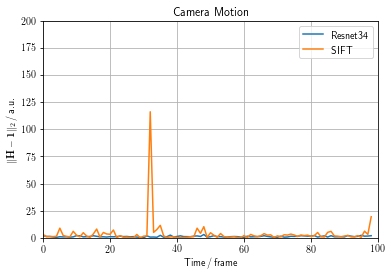

In [18]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

# plot results  
N = 100
step = 1
df = pd.read_pickle('H_{}.pkl'.format(step))

fig, ax = plt.subplots(1, 1)
fig.patch.set_facecolor((1., 1., 1.))
ax.set_ylim(0, 200)
ax.set_xlim(0, N)
ax.set_title('Camera Motion')
ax.set_xlabel(r'Time$\,/\,$frame')
ax.set_ylabel(r'$\lVert\mathbf{H} - \mathbf{1}\rVert_2\,/\,$a.u.')
line_deep, = ax.plot(np.array(0), np.array(0), label='Resnet34')
line_ft, = ax.plot(np.array(0), np.array(0), label='SIFT')
ax.legend(loc='upper right')
ax.grid()

def create_plot(x, y_0, y_1, idx):
    line_deep.set_data(x, y_0)
    if y_1 is not None:
        line_ft.set_data(x, y_1)
    fig.canvas.draw()
    fig.savefig('out/homography_annotation/plot/step_{}/homography_norm_{}.png'.format(step, idx), dpi=300)

dH_deep_list = []
dH_ft_list = []

for idx, row in df.iterrows():
    dH_deep_list.append(np.linalg.norm(row.H_deep - np.eye(3)))
    if row.H_ft is not None:
        dH_ft_list.append(np.linalg.norm(row.H_ft - np.eye(3)))
    else:
        dH_ft_list.append(np.inf)

    if len(dH_deep_list) == N/step:
        dH_deep_list.pop(0)
        dH_ft_list.pop(0)
    
    create_plot(np.arange(0, len(dH_deep_list)*step, step), dH_deep_list, dH_ft_list, idx)

In [ ]:
# create a single plot
